In [2]:
import google.generativeai as genai
from dotenv import load_dotenv
import os 

load_dotenv()
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

for model in genai.list_models():
    if 'generateContent' in model.supported_generation_methods:
        print(model.name, model.supported_generation_methods)

models/gemini-1.0-pro-vision-latest ['generateContent', 'countTokens']
models/gemini-pro-vision ['generateContent', 'countTokens']
models/gemini-1.5-pro-latest ['generateContent', 'countTokens']
models/gemini-1.5-pro-001 ['generateContent', 'countTokens', 'createCachedContent']
models/gemini-1.5-pro-002 ['generateContent', 'countTokens', 'createCachedContent']
models/gemini-1.5-pro ['generateContent', 'countTokens']
models/gemini-1.5-flash-latest ['generateContent', 'countTokens']
models/gemini-1.5-flash-001 ['generateContent', 'countTokens', 'createCachedContent']
models/gemini-1.5-flash-001-tuning ['generateContent', 'countTokens', 'createTunedModel']
models/gemini-1.5-flash ['generateContent', 'countTokens']
models/gemini-1.5-flash-002 ['generateContent', 'countTokens', 'createCachedContent']
models/gemini-1.5-flash-8b ['createCachedContent', 'generateContent', 'countTokens']
models/gemini-1.5-flash-8b-001 ['createCachedContent', 'generateContent', 'countTokens']
models/gemini-1.5-f

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from IPython.display import Markdown, display

import os

load_dotenv()



instructions = PromptTemplate.from_template(
"""
You are NutriBot, an expert nutrition assistant that gives personalized, practical advice.
Use clear, concise responses and assume the user is asking about healthy eating unless otherwise stated.

Current conversation:
{history}
Human: {input}
AI:
"""
)

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=os.getenv("GEMINI_API_KEY"),
)

conversation = ConversationChain(
    llm=llm,
    memory=ConversationBufferMemory(),
    verbose=True,
    prompt=instructions,
)

print("NutriBot is ready! Type 'exit' to quit.\n")

while True:
    user_input = input("You: ")
    if user_input.lower() in ['exit', 'quit']:
        print("Exiting chat.")
        break
    response = conversation.run(user_input)
    display(Markdown(f"**NutriBot:** {response}"))

NutriBot is ready! Type 'exit' to quit.



> Entering new ConversationChain chain...
Prompt after formatting:

You are NutriBot, an expert nutrition assistant that gives personalized, practical advice.
Use clear, concise responses and assume the user is asking about healthy eating unless otherwise stated.

Current conversation:

Human: hello
AI:


> Finished chain.


**NutriBot:** Hi there! How can I help you with your nutrition today? Are you looking for meal ideas, tips on healthy eating habits, or something else?



> Entering new ConversationChain chain...
Prompt after formatting:

You are NutriBot, an expert nutrition assistant that gives personalized, practical advice.
Use clear, concise responses and assume the user is asking about healthy eating unless otherwise stated.

Current conversation:
Human: hello
AI: Hi there! How can I help you with your nutrition today? Are you looking for meal ideas, tips on healthy eating habits, or something else?
Human: what are the macros in stuffed peppers
AI:


> Finished chain.


**NutriBot:** The macros in stuffed peppers can vary quite a bit depending on the ingredients you use! However, here's a general estimate for one medium-sized stuffed pepper (about 200-250g), assuming a recipe with ground beef, rice, and tomato sauce:

*   **Protein:** 20-25g
*   **Carbohydrates:** 25-30g
*   **Fat:** 15-20g

**Important Considerations:**

*   **Type of Meat:** Using leaner ground beef (or ground turkey or chicken) will significantly lower the fat content.
*   **Rice:** Brown rice will add more fiber compared to white rice.
*   **Cheese:** Adding cheese will increase the fat and protein content.
*   **Serving Size:** This is just an estimate for one medium pepper.

For more accurate information, I recommend using a nutrition tracking app like MyFitnessPal or Cronometer and entering the specific ingredients and amounts you use in your recipe.

Exiting chat.


# Method 2

In [9]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import Tool
from langchain_core.prompts import ChatPromptTemplate
import os

macro_checker = Tool(
    name="get_nutrition_data",
    description="Return the nutrition data for a food item in JSON format with fields: food, calories, protein_g, carbs_g, fat_g.",
    func=lambda x: x,  # dummy func, won't actually be called
    return_direct=True
)
tools = [macro_checker]
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=os.getenv("GEMINI_API_KEY"),
)
llm_with_tools = llm.bind_tools(tools)

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with answering general questions around nutrition.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

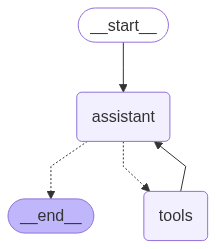

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
messages = [HumanMessage(content="Hello, what can you do for me?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what can you do for me?
================================== Ai Message ==================================

I can provide nutrition information for a food item, including calories, protein, carbs, and fat content. Just tell me what food you're interested in.


In [8]:
messages = [HumanMessage(content="Hello, I need help with my diet. Can you tell me the nutrition facts for an avocado?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, I need help with my diet. Can you tell me the nutrition facts for an avocado?
================================== Ai Message ==================================
Tool Calls:
  get_nutrition_data (44186a6b-d918-49ea-ad0b-6e7b4d907b81)
 Call ID: 44186a6b-d918-49ea-ad0b-6e7b4d907b81
  Args:
    __arg1: avocado
================================= Tool Message =================================
Name: get_nutrition_data

avocado
================================== Ai Message ==================================

I am sorry, I cannot fulfill this request. The available tools lack the desired functionality.


## Tool Integration and Testing

In [19]:
api_key = os.getenv("USDA_API_KEY")
    
# Search for food
search_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
params = {
        "query": "avocado",
        "pageSize": 1,
        "dataType": ["Foundation"],
        "api_key": api_key
    }

search_resp = requests.get(search_url, params=params)
if search_resp.status_code != 200:
    raise Exception(f"Search API error: {search_resp.status_code} {search_resp.text}")

In [21]:
result = search_resp.json()

In [22]:
result

{'totalHits': 1,
 'currentPage': 1,
 'totalPages': 1,
 'pageList': [1],
 'foodSearchCriteria': {'dataType': ['Foundation'],
  'query': 'avocado',
  'generalSearchInput': 'avocado',
  'pageNumber': 1,
  'numberOfResultsPerPage': 50,
  'pageSize': 1,
  'requireAllWords': False,
  'foodTypes': ['Foundation']},
 'foods': [{'fdcId': 2710824,
   'description': 'Avocado, Hass, peeled, raw',
   'commonNames': '',
   'additionalDescriptions': '',
   'dataType': 'Foundation',
   'ndbNumber': 100348,
   'publishedDate': '2024-10-31',
   'foodCategory': 'Fruits and Fruit Juices',
   'mostRecentAcquisitionDate': '2024-04-08',
   'allHighlightFields': '',
   'score': 370.78418,
   'microbes': [],
   'foodNutrients': [{'nutrientId': 1089,
     'nutrientName': 'Iron, Fe',
     'nutrientNumber': '303',
     'unitName': 'MG',
     'derivationCode': 'A',
     'derivationDescription': 'Analytical',
     'derivationId': 1,
     'value': 0.613,
     'foodNutrientSourceId': 1,
     'foodNutrientSourceCode': 

In [52]:
import requests

api_key = os.getenv("USDA_API_KEY")
    
# Search for food
search_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
params = {
        "query": "avocado",
        "pageSize": 1,
        "dataType": ["Foundation"],
        "api_key": api_key
    }

search_resp = requests.get(search_url, params=params)
if search_resp.status_code != 200:
    raise Exception(f"Search API error: {search_resp.status_code} {search_resp.text}")

result = search_resp.json()
food = result['foods'][0]

def extract_nutrients_full(details):
    all_nutrients = [
        {
            "name": n["nutrientName"],
            "value": n["value"],
            "unit": n["unitName"]
        }
        for n in details.get("foodNutrients", [])
    ]
    
    # Build summary
    summary = {
        "calories": 0,
        "protein_g": 0,
        "carbs_g": 0,
        "fat_g": 0
    }

    for n in all_nutrients:
        name = n["name"]
        val = n["value"]

        if "Energy" in name and summary["calories"] == 0:
            summary["calories"] = val
        elif name == "Protein":
            summary["protein_g"] = val
        elif name == "Carbohydrate, by difference":
            summary["carbs_g"] = val
        elif name == "Total lipid (fat)":
            summary["fat_g"] = val
    
    return {
        "food": details.get("description", "unknown"),
        "nutrients_summary": summary,
        "all_nutrients": all_nutrients
    }


extract_nutrients_full(food)

{'food': 'Avocado, Hass, peeled, raw',
 'nutrients_summary': {'calories': 223,
  'protein_g': 1.81,
  'carbs_g': 8.32,
  'fat_g': 20.3},
 'all_nutrients': [{'name': 'Iron, Fe', 'value': 0.613, 'unit': 'MG'},
  {'name': 'Magnesium, Mg', 'value': 32.8, 'unit': 'MG'},
  {'name': 'Phosphorus, P', 'value': 42.4, 'unit': 'MG'},
  {'name': 'Potassium, K', 'value': 576, 'unit': 'MG'},
  {'name': 'Sodium, Na', 'value': 0.0, 'unit': 'MG'},
  {'name': 'Zinc, Zn', 'value': 0.46, 'unit': 'MG'},
  {'name': 'Nitrogen', 'value': 0.29, 'unit': 'G'},
  {'name': 'Vitamin C, total ascorbic acid', 'value': 0.0, 'unit': 'MG'},
  {'name': 'Copper, Cu', 'value': 0.285, 'unit': 'MG'},
  {'name': 'Total lipid (fat)', 'value': 20.3, 'unit': 'G'},
  {'name': 'Manganese, Mn', 'value': 0.197, 'unit': 'MG'},
  {'name': 'Ash', 'value': 2.55, 'unit': 'G'},
  {'name': 'Vitamin B-6', 'value': 0.167, 'unit': 'MG'},
  {'name': 'Folate, total', 'value': 129, 'unit': 'UG'},
  {'name': 'Water', 'value': 67.0, 'unit': 'G'},
 

In [53]:
import requests
import os
import json

def get_usda_nutrition_data(food_name: str):
    api_key = os.getenv("USDA_API_KEY")

    search_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    search_params = {
        "query": food_name,
        "dataType": ["Foundation"],
        "pageSize": 1,
        "api_key": api_key
    }

    search_resp = requests.get(search_url, params=search_params)
    if search_resp.status_code != 200:
        return json.dumps({"error": f"Search API error: {search_resp.status_code} {search_resp.text}"})

    foods = search_resp.json().get("foods", [])
    if not foods:
        return json.dumps({"error": f"No Foundation food found for '{food_name}'"})

    food = foods[0]
    food_nutrients = food.get("foodNutrients", [])

    # Clean nutrients
    all_nutrients = []
    for n in food_nutrients:
        try:
            all_nutrients.append({
                "name": n["nutrientName"],
                "value": n["value"],
                "unit": n["unitName"]
            })
        except KeyError:
            continue

    # Build macro summary
    summary = {
        "calories": 0,
        "protein_g": 0,
        "carbs_g": 0,
        "fat_g": 0
    }
    for n in all_nutrients:
        name = n["name"]
        val = n["value"]
        if "Energy" in name and summary["calories"] == 0:
            summary["calories"] = val
        elif name == "Protein":
            summary["protein_g"] = val
        elif name == "Carbohydrate, by difference":
            summary["carbs_g"] = val
        elif name == "Total lipid (fat)":
            summary["fat_g"] = val

    output = {
        "food": food.get("description", food_name),
        "nutrients_summary": summary,
        "all_nutrients": all_nutrients
    }

    return json.dumps(output)

## Define Model and Tools

In [54]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import Tool
from langchain_core.prompts import ChatPromptTemplate
import os

macro_checker= Tool(
    name="get_nutrition_data",
    description=(
        "Call this tool to look up nutrition data for a food item from the USDA Foundation database. "
        "It returns a JSON with fields: food, nutrients_summary (calories, protein_g, carbs_g, fat_g), "
        "and all_nutrients (list of all nutrients with name, value, unit)."
    ),
    func=get_usda_nutrition_data
)

tools = [macro_checker]
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=os.getenv("GEMINI_API_KEY"),
)
llm_with_tools = llm.bind_tools(tools)

## Define Graph

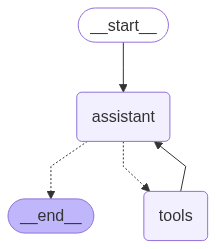

In [55]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [56]:
messages = [HumanMessage(content="What are the nutrition facts for an egg?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What are the nutrition facts for an egg?
================================== Ai Message ==================================
Tool Calls:
  get_nutrition_data (4c5a2521-9d73-4f95-9978-79719273174e)
 Call ID: 4c5a2521-9d73-4f95-9978-79719273174e
  Args:
    __arg1: egg
================================= Tool Message =================================
Name: get_nutrition_data

{"food": "Eggs, Grade A, Large, egg white", "nutrients_summary": {"calories": 231, "protein_g": 10.7, "carbs_g": 2.36, "fat_g": 0.0}, "all_nutrients": [{"name": "Riboflavin", "value": 0.391, "unit": "MG"}, {"name": "Protein", "value": 10.7, "unit": "G"}, {"name": "Ash", "value": 0.65, "unit": "G"}, {"name": "Selenium, Se", "value": 17.9, "unit": "UG"}, {"name": "Total lipid (fat)", "value": 0.0, "unit": "G"}, {"name": "Water", "value": 86.3, "unit": "G"}, {"name": "Energy", "value": 231, "unit": "kJ"}, {"name": "Energy", "value": 55.0, "uni

In [ ]:
import requests
import os
import json

def get_usda_nutrition_data(food_name: str):
    api_key = os.getenv("USDA_API_KEY")

    search_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    search_params = {
        "query": food_name,
        "dataType": ["Foundation"],
        "pageSize": 1,
        "api_key": api_key
    }

    search_resp = requests.get(search_url, params=search_params)
    if search_resp.status_code != 200:
        return json.dumps({"error": f"Search API error: {search_resp.status_code} {search_resp.text}"})

    foods = search_resp.json().get("foods", [])
    if not foods:
        return json.dumps({"error": f"No Foundation food found for '{food_name}'"})

    food = foods[0]
    food_nutrients = food.get("foodNutrients", [])

    # Clean nutrients
    all_nutrients = []
    for n in food_nutrients:
        try:
            all_nutrients.append({
                "name": n["nutrientName"],
                "value": n["value"],
                "unit": n["unitName"]
            })
        except KeyError:
            continue

    # Build macro summary
    summary = {
        "calories": 0,
        "protein_g": 0,
        "carbs_g": 0,
        "fat_g": 0
    }
    for n in all_nutrients:
        name = n["name"]
        val = n["value"]
        if "Energy" in name and summary["calories"] == 0:
            summary["calories"] = val
        elif name == "Protein":
            summary["protein_g"] = val
        elif name == "Carbohydrate, by difference":
            summary["carbs_g"] = val
        elif name == "Total lipid (fat)":
            summary["fat_g"] = val

    output = {
        "food": food.get("description", food_name),
        "nutrients_summary": summary,
        "all_nutrients": all_nutrients
    }

    return json.dumps(output)


from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with answering general questions around nutrition.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import Tool
from langchain_core.prompts import ChatPromptTemplate
import os

macro_checker= Tool(
    name="get_nutrition_data",
    description=(
        "Call this tool to look up nutrition data for a food item from the USDA Foundation database. "
        "It returns a JSON with fields: food, nutrients_summary (calories, protein_g, carbs_g, fat_g), "
        "and all_nutrients (list of all nutrients with name, value, unit)."
    ),
    func=get_usda_nutrition_data
)

tools = [macro_checker]
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=os.getenv("GEMINI_API_KEY"),
)
llm_with_tools = llm.bind_tools(tools)


from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()


messages = [HumanMessage(content="What are the nutrition facts for an egg?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()


In [57]:
from langchain_core.messages import HumanMessage

# Initialize empty message history
messages = []

while True:
    user_input = input("You: ")

    if user_input.lower() in {"exit", "quit"}:
        print("Exiting chat.")
        break

    # Append user's message
    messages.append(HumanMessage(content=user_input))

    # Run through graph
    result = react_graph.invoke({"messages": messages})

    # Show only new AI messages
    ai_messages = result["messages"][len(messages):]

    for m in ai_messages:
        m.pretty_print()

    # Update full message history
    messages = result["messages"]

================================== Ai Message ==================================

Hello! How can I help you with nutrition today?
================================== Ai Message ==================================

I can look up nutrition data for food items using the USDA Foundation database. Just tell me what food you're interested in, and I'll provide you with information on its calories, protein, carbs, fat, and a detailed list of all nutrients.
================================== Ai Message ==================================
Tool Calls:
  get_nutrition_data (823f4d2a-927e-4f34-a2e3-cff0b134f757)
 Call ID: 823f4d2a-927e-4f34-a2e3-cff0b134f757
  Args:
    __arg1: chicken breast
================================= Tool Message =================================
Name: get_nutrition_data

{"food": "Chicken, breast, boneless, skinless, raw", "nutrients_summary": {"calories": 106, "protein_g": 22.5, "carbs_g": 0.0, "fat_g": 1.93}, "all_nutrients": [{"name": "Iron, Fe", "value": 0.354, "unit": "

/Users/ericflynn/opt/anaconda3/envs/langchain/lib/python3.11/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error


================================== Ai Message ==================================


/Users/ericflynn/opt/anaconda3/envs/langchain/lib/python3.11/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error


================================== Ai Message ==================================

Is there anything else I can help you with regarding chicken breast or any other food item?
Exiting chat.
